# Week 11 Notebook: Risk, Bias and Ethical Considerations
The goal of this week's assignment is to build transparency into the prediction process and analyze potential risks and biases in the dataset and model output. This will be achieved by identifying important features, explaining individual predictions, evaluating bias in the input dataset and model outputs, and discussing potential risks of using the model.



### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
import pickle

### Read data as dataframe

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

data_folder = os.path.join(parent_dir,"data")
raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

raw_data_file = os.path.join(raw_data_folder, 'rawSampledData.csv')

In [3]:
# Load the data as a pandas dataframe.
df = pd.read_csv(raw_data_file)
print(df.columns)

Index(['datetime', 'timestamp', 'hour', 'day', 'month', 'timezone', 'source',
       'destination', 'cab_type', 'product_id', 'name', 'price', 'distance',
       'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

## Split the dataset into training, testing, and validation sets
- training set is 70% of the dataframe
- validation set is 20% of the dataframe
- test set is 10% of the dataframe

In [5]:
def train_val_test_split(df):
    # Shuffle the dataset and calculate the size of validation and test sets

    df = df.sample(frac=1, random_state=123)

    val_size = int(len(df) * 0.2)
    test_size = int(len(df) * 0.1)

    # Select rows based on the val_size and test_size to store as train set, val set, and test set
    train_df = df.iloc[val_size + test_size:]
    val_df = df.iloc[:val_size]
    test_df = df.iloc[val_size:val_size + test_size]
    return train_df, val_df, test_df

train_df, val_df, test_df = train_val_test_split(df)

## Feature Engineering

### Create new variables
#### Weather-related Variable
In week 5, `icon`, `short_summary`, and `long_summary`, were combined into one variable to reduce redundancy and dimensionality.


In [6]:
print('Unique classes of icon:')
print(df['icon'].unique())
print('')
print('Unique classes of short_summary:')
print(df['short_summary'].unique())
print('')
print('Unique classes of long_summary:')
print(df['long_summary'].unique())

Unique classes of icon:
[' partly-cloudy-day ' ' rain ' ' cloudy ' ' clear-night ' ' clear-day '
 ' partly-cloudy-night ' ' fog ']

Unique classes of short_summary:
[' Mostly Cloudy ' ' Light Rain ' ' Overcast ' ' Clear ' ' Partly Cloudy '
 ' Rain ' ' Foggy ' ' Drizzle ' ' Possible Drizzle ']

Unique classes of long_summary:
[' Partly cloudy throughout the day. ' ' Light rain until evening. '
 ' Mostly cloudy throughout the day. '
 ' Rain until morning, starting again in the evening. '
 ' Light rain in the morning. ' ' Overcast throughout the day. '
 ' Foggy in the morning. ' ' Light rain in the morning and overnight. '
 ' Rain throughout the day. ' ' Possible drizzle in the morning. '
 ' Rain in the morning and afternoon. ']


We created a custom weighting system by assigning scores to each type of weather event based on severity or relevance. We weight it by evaluating the weather conditions, considering all three variables and visibility as visibility plays a significant role in determining whether weather conditions will impact driving safety. 

In order to calculate the weight, we first needed to understand how these variables reflect the weather on that specific date and assess how severe the conditions are for driving.

In [7]:
weather_df = df[['icon', 'short_summary', 'long_summary']].drop_duplicates()
weather_df.shape

(59, 3)

In [8]:
weather_df[weather_df['icon'] == ' rain ']

,icon,short_summary,long_summary
1,rain,Light Rain,Light rain until evening.
24,rain,Rain,"Rain until morning, starting again in the eve..."
33,rain,Drizzle,Light rain in the morning.
39,rain,Light Rain,Rain throughout the day.
43,rain,Drizzle,"Rain until morning, starting again in the eve..."
46,rain,Light Rain,"Rain until morning, starting again in the eve..."
85,rain,Light Rain,Light rain in the morning.
140,rain,Possible Drizzle,Light rain until evening.
147,rain,Light Rain,Light rain in the morning and overnight.
198,rain,Possible Drizzle,"Rain until morning, starting again in the eve..."


In [9]:
weather_df[weather_df['icon'] == ' cloudy ']

,icon,short_summary,long_summary
2,cloudy,Overcast,Mostly cloudy throughout the day.
5,cloudy,Overcast,"Rain until morning, starting again in the eve..."
6,cloudy,Overcast,Light rain in the morning.
8,cloudy,Overcast,Overcast throughout the day.
16,cloudy,Overcast,Partly cloudy throughout the day.
17,cloudy,Overcast,Rain throughout the day.
28,cloudy,Overcast,Light rain until evening.
36,cloudy,Overcast,Light rain in the morning and overnight.
89,cloudy,Overcast,Foggy in the morning.
933,cloudy,Overcast,Possible drizzle in the morning.


In [10]:
weather_df[weather_df['icon'] == ' fog ']

,icon,short_summary,long_summary
32,fog,Foggy,"Rain until morning, starting again in the eve..."
70,fog,Foggy,Foggy in the morning.
6997,fog,Foggy,Rain in the morning and afternoon.


In [11]:
def weather_severity(row):
    # Initialize severity
    severity = 1

    if 'rain' in row['icon'].strip().lower():
        # If rain is present in the icon, check for light or drizzle
        if 'light' in row['short_summary'].lower() or 'drizzle' in row['short_summary'].lower() or \
           'light' in row['long_summary'].lower() or 'drizzle' in row['long_summary'].lower():
            severity = 2  # Moderate severity for light rain or drizzle
        else:
            severity = 3  # Highest severity for rain without light or drizzle
    elif 'cloudy' in row['icon'].lower() or 'fog' in row['icon'].lower():
        severity = 2  # Moderate severity for clouds and fog

    # Adjust severity based on visibility
    if row['visibility'] < 1:  # Low visibility (less than 1)
        severity += 1  # Increase severity by 1
    elif row['visibility'] >= 7:  # High visibility (7 or more)
        severity -= 1  # Decrease severity by 1
        severity = max(severity, 1)  # Ensure severity doesn't go below 1

    return severity


#### Time-related Variable

We also added the following time related variables in week 5. 

In [12]:
def add_time_features(df):
    # Create rush_hour feature
    df['rush_hour'] = df['hour'].apply(lambda x: 1 if (6 <= x <= 9 or 16 <= x <= 18) else 0)

    # Create weekend feature
    df['weekend'] = df['datetime'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

    # Define game dates for Bruins and Celtics
    bruins = [
        '2018-11-05', '2018-11-08', '2018-11-10', '2018-11-11',
        '2018-11-23', '2018-11-29', '2018-12-01', '2018-12-08',
        '2018-12-11', '2018-12-16', '2018-12-20', '2018-12-22',
        '2018-12-27'
    ] 
    celtics = [
        '2018-11-01', '2018-11-14', '2018-11-16', '2018-11-17',
        '2018-11-21', '2018-11-30', '2018-12-06', '2018-12-10',
        '2018-12-14', '2018-12-19', '2018-12-21', '2018-12-23',
        '2018-12-25'
    ]
    game_dates = bruins + celtics

    # Create game_day feature
    df['game_day'] = df['datetime'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in game_dates else 0)

    return df

In [13]:
train_df = add_time_features(train_df)
val_df = add_time_features(val_df)
test_df = add_time_features(test_df)

In [14]:
def shift_dt(df):
    df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('h')
    df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%dT%H:00')

    return df

In [15]:
train_df = shift_dt(train_df)
val_df = shift_dt(val_df)
test_df = shift_dt(test_df)

## Data Preprocessing
Since we conducted feature engineering on the original data before preprocessing, we will run the pipeline again to get the prepare the data for modeling

### Missing Value Imputation
Uber Taxi Fee Breakdown
 - base fare: $2.60 for first 1/7 mile
 - per minute fare: $0.47
 - per mile: $2.8


In [16]:
def taxi_price_calculator(distance, time):
    base_fare = 2.60
    per_min_fare = 0.47
    per_mile_fare = 2.8
    price = base_fare + distance * per_mile_fare + time * per_min_fare
    return price

## Data Improvement Explored
- Improved the accuracy of the coordinates. Originally, we used Geopy for getting the coordinates which is inaccurate for Theatre District. Geopy gave it a coordinate outside of Boston, even when location was specified.
- We included a time variable that is estimated duration of the ride predicted given source and arrival location using Mapbox. 
- We also explored another way to predict the time variable by factoring the departure time for a more precise ride duration estimate.

The following eta minutes were obtained using Mapbox API. For saving computation resoureces, more details were stored under the `codes/time_calculator_rush_hr.ipynb` and `codes/time_calculator.py`.

In [17]:
rides_with_eta = os.path.join(interim_data_folder, "rides_with_etas.csv")
rides_with_eta_rh = os.path.join(interim_data_folder, "rides_with_etas_rush_hour.csv")
time_df = pd.read_csv(rides_with_eta)
rh_time_df = pd.read_parquet(rides_with_eta_rh)

In [18]:
def calculate_taxi_price(df: pd.DataFrame, time_df: pd.DataFrame, rush_hour = False) -> pd.DataFrame:
    if rush_hour:
         df = pd.merge(df, time_df, on=['source', 'destination', 'datetime'], how = 'left')
         df.loc[df['name'] == 'Taxi', 'price'] = df.loc[df['name']== 'Taxi'].apply(lambda row: taxi_price_calculator(row['distance'], row['eta_minutes']), axis = 1)
    else:
        df = pd.merge(df, time_df, on=['source', 'destination'], how = 'left')
        df.loc[df['name'] == 'Taxi', 'price'] = df.loc[df['name']== 'Taxi'].apply(lambda row: taxi_price_calculator(row['distance'], row['eta_minutes']), axis = 1)

    return df


rh_train_df = calculate_taxi_price(train_df, rh_time_df, rush_hour=True)
rh_val_df = calculate_taxi_price(val_df, rh_time_df, rush_hour=True)
rh_test_df = calculate_taxi_price(test_df, rh_time_df, rush_hour=True)

train_df = calculate_taxi_price(train_df, time_df, rush_hour=False)
val_df = calculate_taxi_price(val_df, time_df, rush_hour=False)
test_df = calculate_taxi_price(test_df, time_df, rush_hour=False)

In [19]:
rh_train_df.head()

,datetime,timestamp,hour,day,month,timezone,source,destination,cab_type,product_id,...,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,rush_hour,weekend,game_day,eta_minutes
0,2018-11-27T08:00,1.543306e+09,8,27,11,America/New_York,Boston University,Financial District,Lyft,lyft,...,46.83,1543320000,32.05,1543377600,43.85,1543320000,1,0,0,19.62
1,2018-12-14T14:00,1.544798e+09,14,14,12,America/New_York,North End,Back Bay,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,...,46.67,1544814000,24.47,1544785200,43.88,1544817600,0,0,1,18.25
2,2018-12-01T02:00,1.543633e+09,2,1,12,America/New_York,South Station,Theatre District,Lyft,lyft_premier,...,42.57,1543600800,27.20,1543568400,40.51,1543611600,0,1,1,6.69
3,2018-12-03T07:00,1.543822e+09,7,3,12,America/New_York,North Station,North End,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,...,57.87,1543852800,39.41,1543896000,57.20,1543852800,1,0,0,4.43
4,2018-12-03T22:00,1.543875e+09,22,3,12,America/New_York,North End,Back Bay,Lyft,lyft_premier,...,57.27,1543852800,39.54,1543896000,56.60,1543852800,0,0,0,13.32


In [20]:
train_na = train_df[train_df['name']=="Taxi"]['price'].isnull().sum()
val_na = val_df[val_df['name']=="Taxi"]['price'].isnull().sum()
test_na = test_df[test_df['name']=="Taxi"]['price'].isnull().sum()
print(f'Number of missing value in train_df: {test_na}')
print(f'Number of missing value in val_df: {val_na}')
print(f'Number of missing value in test_df: {test_na}')
rh_train_na = rh_train_df[rh_train_df['name']=="Taxi"]['price'].isnull().sum()
rh_val_na = rh_val_df[rh_val_df['name']=="Taxi"]['price'].isnull().sum()
rh_test_na = rh_test_df[rh_test_df['name']=="Taxi"]['price'].isnull().sum()
print(f'Number of missing value in rh_train_df: {rh_train_na}')
print(f'Number of missing value in rh_val_df: {rh_val_na}')
print(f'Number of missing value in rh_test_df: {rh_test_na}')

Number of missing value in train_df: 0
Number of missing value in val_df: 0
Number of missing value in test_df: 0
Number of missing value in rh_train_df: 0
Number of missing value in rh_val_df: 0
Number of missing value in rh_test_df: 0


### Drop Uneeded Columns
Some columns are not relevant for modeling because they function solely as unique identifiers and do not provide meaningful information for preduction purposes:
- `id`
- `product_id`

Additionally, we also dropped `timezone` since all data is within the same timezone.

`datetime` and`timestamp` were dropped to reduce redundacy with other time features.

`visibility.1` is duplicated with  `visibility`

In [21]:
columns_to_drop = ['timezone', 'datetime', 'product_id', 'visibility.1', 'timestamp','short_summary', 'long_summary', 'icon']

train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

rh_train_df = rh_train_df.drop(columns=columns_to_drop)
rh_val_df = rh_val_df.drop(columns=columns_to_drop)
rh_test_df = rh_test_df.drop(columns=columns_to_drop)

We had previously dropped the variable `eta_minutes` as well, but we added this variable back in for week 10. We hope to identify whether including this variable improves the performance of our winning model, the pruned Decision Tree.

### Encoding Categorical Variables
#### Check dtypes

In [22]:
object_columns = train_df.select_dtypes(include=['object']).columns.tolist()

# Display the object columns
print("Object Columns:")
print(object_columns)

Object Columns:
['source', 'destination', 'cab_type', 'name']



#### Encoding `source` and `destination` variables

In [23]:
train_df['source'] = train_df['source'].str.strip().str.replace(' ', '_')
val_df['source'] = val_df['source'].str.strip().str.replace(' ', '_')
test_df['source'] = test_df['source'].str.strip().str.replace(' ', '_')

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training data 'source' column
train_encoded_summary = encoder.fit_transform(train_df[['source']])

# Apply the encoder to validation and test sets using the trained categories from the training data
val_encoded_summary = encoder.transform(val_df[['source']])
test_encoded_summary = encoder.transform(test_df[['source']])

# Convert the encoded arrays back to pandas DataFrames with appropriate column names
train_encoded_summary_df = pd.DataFrame(train_encoded_summary, columns=encoder.get_feature_names_out(['source']))
val_encoded_summary_df = pd.DataFrame(val_encoded_summary, columns=encoder.get_feature_names_out(['source']))
test_encoded_summary_df = pd.DataFrame(test_encoded_summary, columns=encoder.get_feature_names_out(['source']))

# Concatenate the one-hot encoded 'source' columns back to the respective datasets
train_df = pd.concat([train_df.reset_index(drop=True), train_encoded_summary_df], axis=1)
val_df = pd.concat([val_df.reset_index(drop=True), val_encoded_summary_df], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_encoded_summary_df], axis=1)

In [24]:
rh_train_df['source'] = rh_train_df['source'].str.strip().str.replace(' ', '_')
rh_val_df['source'] = rh_val_df['source'].str.strip().str.replace(' ', '_')
rh_test_df['source'] = rh_test_df['source'].str.strip().str.replace(' ', '_')

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training data 'source' column
rh_train_encoded_summary = encoder.fit_transform(rh_train_df[['source']])

# Apply the encoder to validation and test sets using the trained categories from the training data
rh_val_encoded_summary = encoder.transform(rh_val_df[['source']])
rh_test_encoded_summary = encoder.transform(rh_test_df[['source']])

# Convert the encoded arrays back to pandas DataFrames with appropriate column names
rh_train_encoded_summary_df = pd.DataFrame(rh_train_encoded_summary, columns=encoder.get_feature_names_out(['source']))
rh_val_encoded_summary_df = pd.DataFrame(rh_val_encoded_summary, columns=encoder.get_feature_names_out(['source']))
rh_test_encoded_summary_df = pd.DataFrame(rh_test_encoded_summary, columns=encoder.get_feature_names_out(['source']))

# Concatenate the one-hot encoded 'source' columns back to the respective datasets
rh_train_df = pd.concat([rh_train_df.reset_index(drop=True), rh_train_encoded_summary_df], axis=1)
rh_val_df = pd.concat([rh_val_df.reset_index(drop=True), rh_val_encoded_summary_df], axis=1)
rh_test_df = pd.concat([rh_test_df.reset_index(drop=True), rh_test_encoded_summary_df], axis=1)


In [25]:
# Step 1: Extract the categories from the fitted OneHotEncoder for 'source'
source_categories = encoder.categories_[0]

# Initialize a new OneHotEncoder for 'destination'
destination_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Strip leading/trailing spaces and replace blank spaces with underscores in the destination column
train_df['destination'] = train_df['destination'].str.strip().str.replace(' ', '_')
val_df['destination'] = val_df['destination'].str.strip().str.replace(' ', '_')
test_df['destination'] = test_df['destination'].str.strip().str.replace(' ', '_')

# Fit the encoder on the training data 'destination' column
train_encoded_destination = destination_encoder.fit_transform(train_df[['destination']])

# Apply the encoder to validation and test sets using the trained categories from the training data
val_encoded_destination = destination_encoder.transform(val_df[['destination']])
test_encoded_destination = destination_encoder.transform(test_df[['destination']])

# Convert the encoded arrays back to pandas DataFrames with appropriate column names
train_encoded_destination_df = pd.DataFrame(train_encoded_destination, columns=destination_encoder.get_feature_names_out(['destination']))
val_encoded_destination_df = pd.DataFrame(val_encoded_destination, columns=destination_encoder.get_feature_names_out(['destination']))
test_encoded_destination_df = pd.DataFrame(test_encoded_destination, columns=destination_encoder.get_feature_names_out(['destination']))

# Concatenate the one-hot encoded 'destination' columns back to the respective datasets
train_df = pd.concat([train_df.reset_index(drop=True), train_encoded_destination_df], axis=1)
val_df = pd.concat([val_df.reset_index(drop=True), val_encoded_destination_df], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_encoded_destination_df], axis=1)

In [26]:
# Step 1: Extract the categories from the fitted OneHotEncoder for 'source'
source_categories = encoder.categories_[0]

# Initialize a new OneHotEncoder for 'destination'
destination_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Strip leading/trailing spaces and replace blank spaces with underscores in the destination column
rh_train_df['destination'] = rh_train_df['destination'].str.strip().str.replace(' ', '_')
rh_val_df['destination'] = rh_val_df['destination'].str.strip().str.replace(' ', '_')
rh_test_df['destination'] = rh_test_df['destination'].str.strip().str.replace(' ', '_')

# Fit the encoder on the training data 'destination' column
rh_train_encoded_destination = destination_encoder.fit_transform(rh_train_df[['destination']])

# Apply the encoder to validation and test sets using the trained categories from the training data
rh_val_encoded_destination = destination_encoder.transform(rh_val_df[['destination']])
rh_test_encoded_destination = destination_encoder.transform(rh_test_df[['destination']])

# Convert the encoded arrays back to pandas DataFrames with appropriate column names
rh_train_encoded_destination_df = pd.DataFrame(rh_train_encoded_destination, columns=destination_encoder.get_feature_names_out(['destination']))
rh_val_encoded_destination_df = pd.DataFrame(rh_val_encoded_destination, columns=destination_encoder.get_feature_names_out(['destination']))
rh_test_encoded_destination_df = pd.DataFrame(rh_test_encoded_destination, columns=destination_encoder.get_feature_names_out(['destination']))

# Concatenate the one-hot encoded 'destination' columns back to the respective datasets
rh_train_df = pd.concat([rh_train_df.reset_index(drop=True), rh_train_encoded_destination_df], axis=1)
rh_val_df = pd.concat([rh_val_df.reset_index(drop=True), rh_val_encoded_destination_df], axis=1)
rh_test_df = pd.concat([rh_test_df.reset_index(drop=True), rh_test_encoded_destination_df], axis=1)


#### Encoding 'cab_type' and 'name' variables

In [27]:
train_df['name'] = train_df['name'].str.strip().str.replace(' ', '_')
val_df['name'] = val_df['name'].str.strip().str.replace(' ', '_')
test_df['name'] = test_df['name'].str.strip().str.replace(' ', '_')

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training data 'name' column
train_encoded_summary = encoder.fit_transform(train_df[['name']])

# Apply the encoder to validation and test sets using the trained categories from the training data
val_encoded_summary = encoder.transform(val_df[['name']])
test_encoded_summary = encoder.transform(test_df[['name']])

# Convert the encoded arrays back to pandas DataFrames with appropriate column names
train_encoded_summary_df = pd.DataFrame(train_encoded_summary, columns=encoder.get_feature_names_out(['name']))
val_encoded_summary_df = pd.DataFrame(val_encoded_summary, columns=encoder.get_feature_names_out(['name']))
test_encoded_summary_df = pd.DataFrame(test_encoded_summary, columns=encoder.get_feature_names_out(['name']))

# Concatenate the one-hot encoded 'name' columns back to the respective datasets
train_df = pd.concat([train_df.reset_index(drop=True), train_encoded_summary_df], axis=1)
val_df = pd.concat([val_df.reset_index(drop=True), val_encoded_summary_df], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_encoded_summary_df], axis=1)

In [28]:
rh_train_df['name'] = rh_train_df['name'].str.strip().str.replace(' ', '_')
rh_val_df['name'] = rh_val_df['name'].str.strip().str.replace(' ', '_')
rh_test_df['name'] = rh_test_df['name'].str.strip().str.replace(' ', '_')

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training data 'name' column
rh_train_encoded_summary = encoder.fit_transform(rh_train_df[['name']])

# Apply the encoder to validation and test sets using the trained categories from the training data
rh_val_encoded_summary = encoder.transform(rh_val_df[['name']])
rh_test_encoded_summary = encoder.transform(rh_test_df[['name']])

# Convert the encoded arrays back to pandas DataFrames with appropriate column names
rh_train_encoded_summary_df = pd.DataFrame(rh_train_encoded_summary, columns=encoder.get_feature_names_out(['name']))
rh_val_encoded_summary_df = pd.DataFrame(rh_val_encoded_summary, columns=encoder.get_feature_names_out(['name']))
rh_test_encoded_summary_df = pd.DataFrame(rh_test_encoded_summary, columns=encoder.get_feature_names_out(['name']))

# Concatenate the one-hot encoded 'name' columns back to the respective datasets
rh_train_df = pd.concat([rh_train_df.reset_index(drop=True), rh_train_encoded_summary_df], axis=1)
rh_val_df = pd.concat([rh_val_df.reset_index(drop=True), rh_val_encoded_summary_df], axis=1)
rh_test_df = pd.concat([rh_test_df.reset_index(drop=True), rh_test_encoded_summary_df], axis=1)


In [29]:
train_df['cab_type'] = train_df['cab_type'].str.strip()
val_df['cab_type'] = val_df['cab_type'].str.strip()
test_df['cab_type'] = test_df['cab_type'].str.strip()

# Ensure there are no leading or trailing spaces in the 'cab_type' column
train_df['cab_type'] = train_df['cab_type'].str.strip()
val_df['cab_type'] = val_df['cab_type'].str.strip()
test_df['cab_type'] = test_df['cab_type'].str.strip()

# Create dummy variables for the 'cab_type' column
train_df = pd.get_dummies(train_df, columns=['cab_type'], drop_first=True)
val_df = pd.get_dummies(val_df, columns=['cab_type'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['cab_type'], drop_first=True)

In [30]:
rh_train_df['cab_type'] = rh_train_df['cab_type'].str.strip()
rh_val_df['cab_type'] = rh_val_df['cab_type'].str.strip()
rh_test_df['cab_type'] = rh_test_df['cab_type'].str.strip()

# Ensure there are no leading or trailing spaces in the 'cab_type' column
rh_train_df['cab_type'] = rh_train_df['cab_type'].str.strip()
rh_val_df['cab_type'] = rh_val_df['cab_type'].str.strip()
rh_test_df['cab_type'] = rh_test_df['cab_type'].str.strip()

# Create dummy variables for the 'cab_type' column
rh_train_df = pd.get_dummies(rh_train_df, columns=['cab_type'], drop_first=True)
rh_val_df = pd.get_dummies(rh_val_df, columns=['cab_type'], drop_first=True)
rh_test_df = pd.get_dummies(rh_test_df, columns=['cab_type'], drop_first=True)

#### Drop encoded categorical columns

In [31]:
cat_columns_to_drop = ['source',
 'destination',
 'name']

train_df = train_df.drop(columns = cat_columns_to_drop)
val_df = val_df.drop(columns = cat_columns_to_drop)
test_df = test_df.drop(columns = cat_columns_to_drop)

rh_train_df = rh_train_df.drop(columns=cat_columns_to_drop)
rh_val_df = rh_val_df.drop(columns=cat_columns_to_drop)
rh_test_df = rh_test_df.drop(columns=cat_columns_to_drop)


In [32]:
print(train_df.shape)
print(rh_train_df.shape)

(70000, 86)
(70000, 86)


### Standardization and PCA
#### Let's standardize our features

In [33]:
y_train = train_df[['price']]
y_val = val_df[['price']]
y_test = test_df[['price']]

X_train = train_df.drop('price', axis = 1)
X_val = val_df.drop('price', axis = 1)
X_test = test_df.drop('price', axis = 1)

In [34]:
rh_y_train = rh_train_df[['price']]
rh_y_val = rh_val_df[['price']]
rh_y_test = rh_test_df[['price']]

rh_X_train = rh_train_df.drop('price', axis=1)
rh_X_val = rh_val_df.drop('price', axis=1)
rh_X_test = rh_test_df.drop('price', axis=1)

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [36]:
scaler = StandardScaler()
rh_X_train_scaled = scaler.fit_transform(rh_X_train)
rh_X_val_scaled = scaler.transform(rh_X_val)
rh_X_test_scaled = scaler.transform(rh_X_test)

rh_X_train_scaled = pd.DataFrame(rh_X_train_scaled, columns=rh_X_train.columns)
rh_X_val_scaled = pd.DataFrame(rh_X_val_scaled, columns=rh_X_val.columns)
rh_X_test_scaled = pd.DataFrame(rh_X_test_scaled, columns=rh_X_test.columns)


### Re-train the Pruned Decision Tree Model using enhanced data

In [37]:
def evaluate_model(y_true, y_pred, individual_cases = False):
    if individual_cases == True:
        rmse = root_mean_squared_error(y_true, y_pred)
        mse = rmse**2
        return mse, rmse

    else:
        rmse = root_mean_squared_error(y_true, y_pred)
        mse = rmse**2
        r2 = r2_score(y_true, y_pred)
        return mse, rmse, r2

def mean_squared_error(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    return mse

In [38]:
dtr = DecisionTreeRegressor(
    max_depth=20,
    min_samples_split=7,
    min_samples_leaf=10,
    ccp_alpha=0.001,
    random_state=42
)

# Fit the model to the training data
dtr.fit(X_train_scaled, y_train)

dtr_rh = DecisionTreeRegressor(
    max_depth=20,
    min_samples_split=7,
    min_samples_leaf=10,
    ccp_alpha=0.001,
    random_state=42
)

# Fit the model to the training data
dtr_rh.fit(rh_X_train_scaled, rh_y_train)


DecisionTreeRegressor(ccp_alpha=0.001, max_depth=20, min_samples_leaf=10,
                      min_samples_split=7, random_state=42)

In [39]:
# Predicting on training, validation, and test sets for the first decision tree (dtr)
y_train_pred_tree = dtr.predict(X_train_scaled)
y_val_pred_tree = dtr.predict(X_val_scaled)
y_test_pred_tree = dtr.predict(X_test_scaled)

# Predicting on training, validation, and test sets for the second decision tree (dtr_rh)
rh_y_train_pred_tree = dtr_rh.predict(rh_X_train_scaled)
rh_y_val_pred_tree = dtr_rh.predict(rh_X_val_scaled)
rh_y_test_pred_tree = dtr_rh.predict(rh_X_test_scaled)

# Evaluate performance for the first decision tree (dtr)
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)

# Evaluate performance for the second decision tree (dtr_rh)
rh_train_mse_tree, rh_train_rmse_tree, rh_train_r2_tree = evaluate_model(rh_y_train, rh_y_train_pred_tree)
rh_val_mse_tree, rh_val_rmse_tree, rh_val_r2_tree = evaluate_model(rh_y_val, rh_y_val_pred_tree)
rh_test_mse_tree, rh_test_rmse_tree, rh_test_r2_tree = evaluate_model(rh_y_test, rh_y_test_pred_tree)

# Print training metrics for dtr
print("Decision Tree w/ ETA minutes:")
print("Decision Tree Regression Model (dtr) - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics for dtr
print("\nDecision Tree Regression Model (dtr) - Validation Metrics:")
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print test metrics for dtr
print("\nDecision Tree Regression Model (dtr) - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

print("\nDecision Tree w/ ETA minutes factoring departing time:")
print("Decision Tree Regression Model (dtr_rh) - Training Metrics:")
print(f"MSE: {rh_train_mse_tree:.4f}, RMSE: {rh_train_rmse_tree:.4f}, R²: {rh_train_r2_tree:.4f}")

# Print validation metrics for dtr_rh
print("\nDecision Tree Regression Model (dtr_rh) - Validation Metrics:")
print(f"MSE: {rh_val_mse_tree:.4f}, RMSE: {rh_val_rmse_tree:.4f}, R²: {rh_val_r2_tree:.4f}")

# Print test metrics for dtr_rh
print("\nDecision Tree Regression Model (dtr_rh) - Test Metrics:")
print(f"MSE: {rh_test_mse_tree:.4f}, RMSE: {rh_test_rmse_tree:.4f}, R²: {rh_test_r2_tree:.4f}")


Decision Tree w/ ETA minutes:
Decision Tree Regression Model (dtr) - Training Metrics:
MSE: 2.6491, RMSE: 1.6276, R²: 0.9679

Decision Tree Regression Model (dtr) - Validation Metrics:
MSE: 3.0148, RMSE: 1.7363, R²: 0.9631

Decision Tree Regression Model (dtr) - Test Metrics:
MSE: 3.0452, RMSE: 1.7450, R²: 0.9635

Decision Tree w/ ETA minutes factoring departing time:
Decision Tree Regression Model (dtr_rh) - Training Metrics:
MSE: 2.6874, RMSE: 1.6393, R²: 0.9675

Decision Tree Regression Model (dtr_rh) - Validation Metrics:
MSE: 3.0487, RMSE: 1.7460, R²: 0.9628

Decision Tree Regression Model (dtr_rh) - Test Metrics:
MSE: 3.0047, RMSE: 1.7334, R²: 0.9641


# Week 11: New code

### Feature Importance Analysis

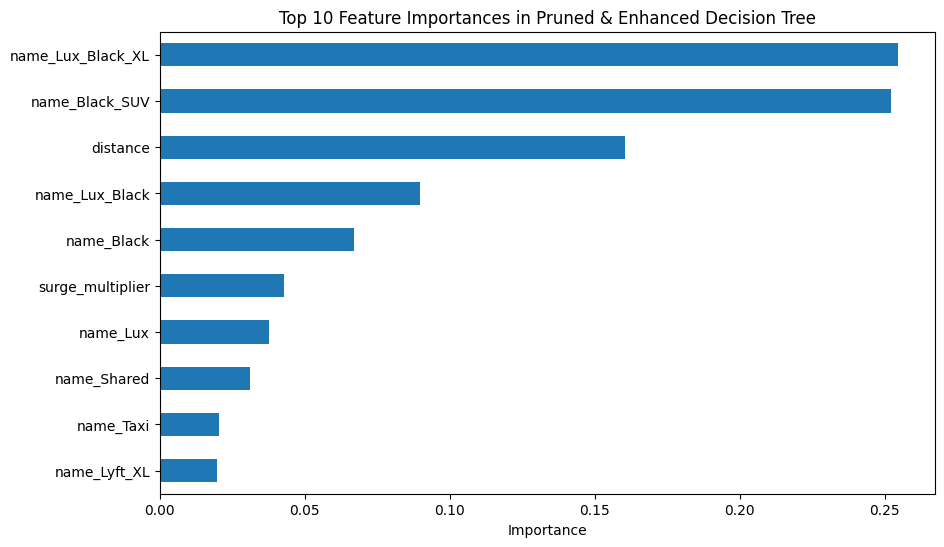

In [40]:

# Feature importances from the pruned/enhanced decision tree model
feature_importances = pd.Series(dtr_rh.feature_importances_, index=rh_X_train.columns).sort_values(ascending=False)

top_10_features = feature_importances.sort_values(ascending=False).head(10)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh', title="Top 10 Feature Importances in Pruned & Enhanced Decision Tree")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.xlabel('Importance')
plt.show()

All of the variables above are related to the variable name which indicates the type of car, and the variable distance which indicates the distance of the ride.

We will look at a few more variables.

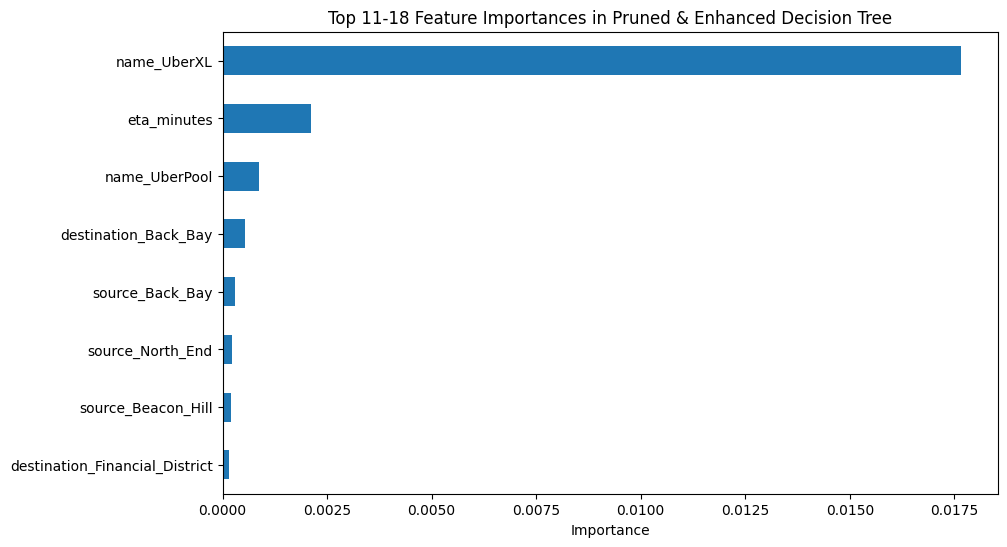

In [41]:
# Sort feature importances in descending order
next_features = feature_importances.iloc[10:18].sort_values(ascending=False)

# Plot the next important features (11-18)
plt.figure(figsize=(10, 6))
next_features.plot(kind='barh', title="Top 11-18 Feature Importances in Pruned & Enhanced Decision Tree")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.xlabel('Importance')
plt.show()

These variables are mostly related to the source and destination of the ride.

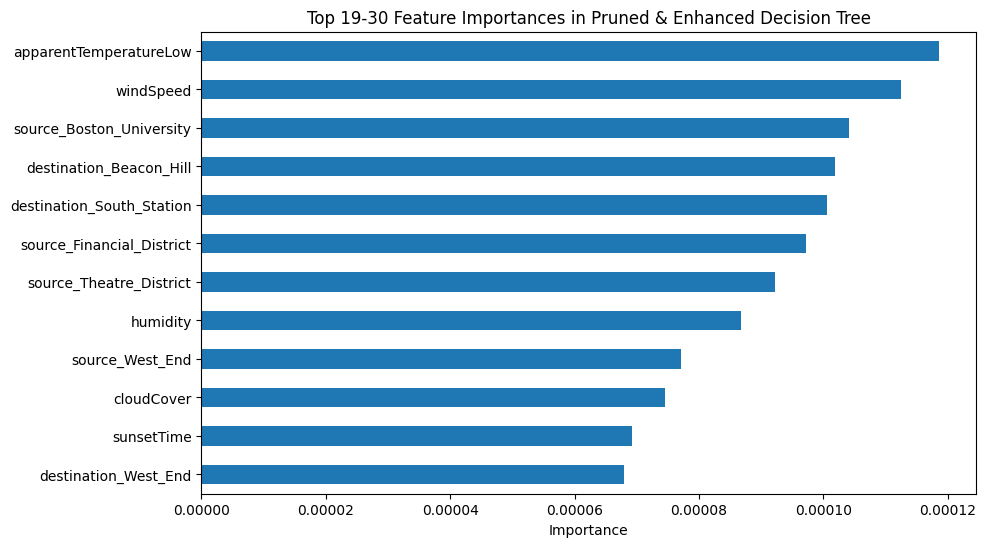

In [42]:
# Sort feature importances in descending order for the range 19-30
next_features_19_30 = feature_importances.iloc[18:30].sort_values(ascending=False)

# Plot the next important features (19-30)
plt.figure(figsize=(10, 6))
next_features_19_30.plot(kind='barh', title="Top 19-30 Feature Importances in Pruned & Enhanced Decision Tree")
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.xlabel('Importance')
plt.show()


This plot includes some weather related variables: `apparentTemperatureLow`, `windSpeed`, `humidity`, `cloudCover`, and `sunsetTime`.

### Extract and analyze 5 individual predictions

In [43]:
# Extract 5 random predictions from the test set
np.random.seed(41)
sample_indices = np.random.choice(rh_X_test.index, size=5, replace=False)
sample_actual = rh_y_test.loc[sample_indices]
sample_predictions = dtr_rh.predict(rh_X_test_scaled.loc[sample_indices])

In [44]:
# Analyze prediction errors
print("Individual Prediction Analysis:")
for i, idx in enumerate(sample_indices):
    actual_price = sample_actual.loc[idx].values[0]
    predicted_price = sample_predictions[i]
    absolute_error = abs(actual_price - predicted_price)
    percentage_error = (absolute_error / actual_price) * 100

    print(f"\nSample {i + 1}:")
    print(f"  Actual Price: ${actual_price:.2f}")
    print(f"  Predicted Price: ${predicted_price:.2f}")
    print(f"  Absolute Error: ${absolute_error:.2f}")
    print(f"  Percentage Error: {percentage_error:.2f}%")

Individual Prediction Analysis:

Sample 1:
  Actual Price: $9.50
  Predicted Price: $10.58
  Absolute Error: $1.08
  Percentage Error: 11.41%

Sample 2:
  Actual Price: $36.00
  Predicted Price: $20.50
  Absolute Error: $15.50
  Percentage Error: 43.06%

Sample 3:
  Actual Price: $22.50
  Predicted Price: $19.60
  Absolute Error: $2.90
  Percentage Error: 12.90%

Sample 4:
  Actual Price: $13.50
  Predicted Price: $16.84
  Absolute Error: $3.34
  Percentage Error: 24.76%

Sample 5:
  Actual Price: $45.00
  Predicted Price: $48.18
  Absolute Error: $3.18
  Percentage Error: 7.07%


### Analysis and quantification of bias

This step is to check whether specific classes  systematically result in higher or lower prediction errors compared to other classes. We will look at the 10 most important features, which were indicated earlier. 

In [45]:
# Bias analysis by comparing prediction errors across top 10 features
top_10_features = feature_importances.index[:10]
bias_metrics = []
for feature in top_10_features:
    unique_values = rh_X_test[feature].unique()
    if len(unique_values) <= 10:  # If the feature has 10 or fewer unique values, treat it as categorical
        for value in unique_values:
            # Filter test data for each group within the feature
            mask = rh_X_test[feature] == value
            y_test_masked = rh_y_test[mask]
            y_pred_masked = dtr_rh.predict(X_test_scaled[mask])

            # Evaluate model performance using the custom evaluate_model function
            mse, _ = evaluate_model(y_test_masked, y_pred_masked, individual_cases=True)
            #bias_metrics[(feature, value)] = {'MSE': mse}
            bias_metrics.append({'Feature': feature, 'Group': value, 'MSE': mse})

bias_metrics_df = pd.DataFrame(bias_metrics)
print("MSE Bias Analysis for Top 10 Important Features:")
print(bias_metrics_df)

MSE Bias Analysis for Top 10 Important Features:
              Feature  Group         MSE
0   name_Lux_Black_XL   0.00    3.047290
1   name_Lux_Black_XL   1.00    4.213786
2      name_Black_SUV   0.00    2.998023
3      name_Black_SUV   1.00    4.602260
4      name_Lux_Black   1.00    3.011131
5      name_Lux_Black   0.00    3.143106
6          name_Black   0.00    3.155420
7          name_Black   1.00    2.880146
8    surge_multiplier   1.00    2.921921
9    surge_multiplier   1.25    5.515025
10   surge_multiplier   2.00   19.060446
11   surge_multiplier   1.50    7.250132
12   surge_multiplier   1.75   18.562605
13   surge_multiplier   3.00  203.062500
14   surge_multiplier   2.50   40.038496
15           name_Lux   0.00    3.186365
16           name_Lux   1.00    2.450849
17        name_Shared   0.00    3.166403
18        name_Shared   1.00    2.739856
19          name_Taxi   0.00    3.265949
20          name_Taxi   1.00    1.594805
21       name_Lyft_XL   0.00    3.213049
22      

### Clean up/treat the input data, remove bias, and retrain model. 

Detect and remove outliers, apply transformations if necessary, and address any imbalances.

In [46]:
rh_X_train_scaled 

,hour,day,month,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,precipIntensity,...,name_Lux_Black_XL,name_Lyft,name_Lyft_XL,name_Shared,name_Taxi,name_UberPool,name_UberX,name_UberXL,name_WAV,cab_type_Uber
0,-0.521974,0.924819,-1.194155,2.185817,-0.151374,0.584975,0.151520,0.698572,0.384928,2.385029,...,-0.282631,3.548182,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,-1.111142
1,0.341435,-0.380165,0.837412,0.571289,-0.151374,0.288779,0.092486,-0.519390,-0.249390,-0.332299,...,-0.282631,-0.281834,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,0.899975
2,-1.385384,-1.685148,0.837412,-0.823873,-0.151374,0.549515,0.003936,-0.399226,-0.192529,-0.332299,...,-0.282631,-0.281834,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,-1.111142
3,-0.665876,-1.484382,0.837412,-0.973042,-0.151374,-2.570974,1.632273,1.140658,1.440019,-0.332299,...,-0.282631,-0.281834,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,0.899975
4,1.492648,-1.484382,0.837412,0.290502,-0.151374,0.288779,0.545075,1.413624,1.302289,-0.332299,...,-0.282631,-0.281834,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,-1.111142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.234171,0.824436,-1.194155,-0.902845,-0.151374,0.259576,-1.929407,0.269837,0.698296,-0.332299,...,-0.282631,-0.281834,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,3.431965,0.899975
69996,0.773140,1.025202,-1.194155,-0.973042,-0.151374,0.549515,0.003936,0.176376,-0.092706,-0.332299,...,-0.282631,-0.281834,3.530457,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,-1.111142
69997,1.492648,-0.179398,0.837412,1.861157,-0.151374,0.255405,-0.729061,0.415221,0.201709,-0.273306,...,-0.282631,3.548182,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,-1.111142
69998,0.917041,-0.279781,0.837412,0.887175,-0.151374,0.432705,-0.222358,2.066369,2.228495,-0.332299,...,3.538182,-0.281834,-0.283249,-0.28463,-0.295542,-0.290772,-0.29002,-0.294082,-0.291378,-1.111142


In [47]:
# Remove price outliers beyond 3 standard deviations for `price`
price_mean, price_std = rh_train_df['price'].mean(), rh_train_df['price'].std()
rh_train_df = rh_train_df[rh_train_df['price'] < price_mean + 3 * price_std]

# Re-split data after outlier removal
rh_X_train = rh_train_df.drop('price', axis=1)
rh_y_train = rh_train_df[['price']]
rh_X_train_scaled = scaler.fit_transform(rh_X_train)

rh_X_train_scaled = pd.DataFrame(rh_X_train_scaled, columns=rh_X_train.columns)
# Retrain the pruned decision tree model on cleaned data
dtr_rh_cleaned = DecisionTreeRegressor(
    max_depth=20,
    min_samples_split=7,
    min_samples_leaf=10,
    ccp_alpha=0.001,
    random_state=42
)
dtr_rh_cleaned.fit(rh_X_train_scaled, rh_y_train)

# Evaluate cleaned model on train, validation, and test sets
rh_y_train_pred_cleaned = dtr_rh_cleaned.predict(rh_X_train_scaled)
rh_y_val_pred_cleaned = dtr_rh_cleaned.predict(rh_X_val_scaled)
rh_y_test_pred_cleaned = dtr_rh_cleaned.predict(rh_X_test_scaled)

# Evaluate and compare performance
rh_train_mse_cleaned, rh_train_rmse_cleaned, rh_train_r2_cleaned = evaluate_model(rh_y_train, rh_y_train_pred_cleaned)
rh_val_mse_cleaned, rh_val_rmse_cleaned, rh_val_r2_cleaned = evaluate_model(rh_y_val, rh_y_val_pred_cleaned)
rh_test_mse_cleaned, rh_test_rmse_cleaned, rh_test_r2_cleaned = evaluate_model(rh_y_test, rh_y_test_pred_cleaned)

# Print comparison of original and cleaned model performance
print("Original Model - Training Metrics:")
print(f"MSE: {rh_train_mse_tree:.4f}, RMSE: {rh_train_rmse_tree:.4f}, R²: {rh_train_r2_tree:.4f}")
print("Original Model - Validation Metrics:")
print(f"MSE: {rh_val_mse_tree:.4f}, RMSE: {rh_val_rmse_tree:.4f}, R²: {rh_val_r2_tree:.4f}")
print("Original Model - Test Metrics:")
print(f"MSE: {rh_test_mse_tree:.4f}, RMSE: {rh_test_rmse_tree:.4f}, R²: {rh_test_r2_tree:.4f}")

print("\nCleaned Model - Training Metrics:")
print(f"MSE: {rh_train_mse_cleaned:.4f}, RMSE: {rh_train_rmse_cleaned:.4f}, R²: {rh_train_r2_cleaned:.4f}")
print("Cleaned Model - Validation Metrics:")
print(f"MSE: {rh_val_mse_cleaned:.4f}, RMSE: {rh_val_rmse_cleaned:.4f}, R²: {rh_val_r2_cleaned:.4f}")
print("Cleaned Model - Test Metrics:")
print(f"MSE: {rh_test_mse_cleaned:.4f}, RMSE: {rh_test_rmse_cleaned:.4f}, R²: {rh_test_r2_cleaned:.4f}")


Original Model - Training Metrics:
MSE: 2.6874, RMSE: 1.6393, R²: 0.9675
Original Model - Validation Metrics:
MSE: 3.0487, RMSE: 1.7460, R²: 0.9628
Original Model - Test Metrics:
MSE: 3.0047, RMSE: 1.7334, R²: 0.9641

Cleaned Model - Training Metrics:
MSE: 2.4145, RMSE: 1.5539, R²: 0.9669
Cleaned Model - Validation Metrics:
MSE: 3.9563, RMSE: 1.9890, R²: 0.9517
Cleaned Model - Test Metrics:
MSE: 3.9086, RMSE: 1.9770, R²: 0.9533


Removing data that has outliers for the variable `price` beyond 3 standard deviations did not improve our prediction model. The CLEANED pruned and enhanced decision tree model has a higher MSE and RMSE, and a slightly lower r-squared. 